In [ ]:
!pip install tensorly
!pip install tensorflow
!pip install opencv-python
!pip install pillow

# Adaptive HOSVD-Based Image Denoising Using a Lightweight ResNet for Threshold Prediction

لطفاً تصویر خود را آپلود کنید...


Saving boat_850.jpg to boat_850 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


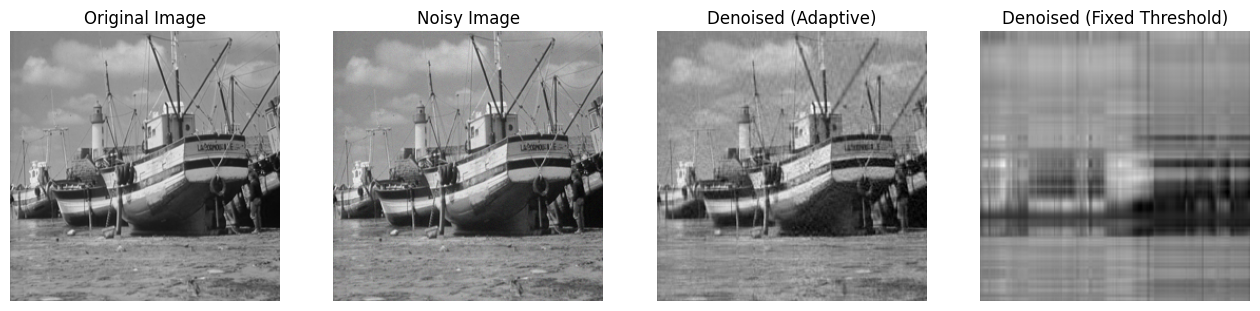

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
from scipy.ndimage import gaussian_filter

tl.set_backend('tensorflow')

def preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = gaussian_filter(img_array, sigma=0.3)
    return img_array

def residual_block(x, filters, strides=1):
    shortcut = x
    y = layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    y = layers.Conv2D(filters, 3, padding='same')(y)
    y = layers.BatchNormalization()(y)

    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    out = layers.Add()([shortcut, y])
    out = layers.ReLU()(out)
    return out


def create_resnet_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = residual_block(x, 64)
    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128)

    x = layers.GlobalAveragePooling2D()(x)
    threshold = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=threshold)
    return model

def apply_hosvd_adaptive(image, threshold):
    tensor = tl.tensor(image, dtype=tl.float32)
    core, factors = tucker(tensor, rank=[40, 40, 3])
    adjusted_threshold = max(0.05, min(0.15, threshold * tl.max(tl.abs(core))))
    core = tl.where(tl.abs(core) < adjusted_threshold, 0, core)
    denoised_image = tl.tucker_to_tensor((core, factors))
    denoised_image = np.clip(denoised_image, 0, 1)
    return denoised_image

def apply_hosvd_fixed(image, threshold=0.1):
    tensor = tl.tensor(image, dtype=tl.float32)
    core, factors = tucker(tensor, rank=[40, 40, 3])
    core = tl.where(tl.abs(core) < threshold * tl.max(tl.abs(core)), 0, core)
    denoised_image = tl.tucker_to_tensor((core, factors))
    denoised_image = np.clip(denoised_image, 0, 1)
    return denoised_image

def denoise_image(image_path, model):
    img = preprocess_image(image_path)
    noise = np.random.normal(0, 0.01, img.shape)
    noisy_img = np.clip(img + noise, 0, 1)

    img_input = np.expand_dims(noisy_img, axis=0)

    noisy_batch = np.tile(img_input, (10, 1, 1, 1))
    clean_batch = np.tile(np.expand_dims(img, axis=0), (10, 1, 1, 1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(noisy_batch, np.zeros((10, 1)), epochs=5, verbose=0)

    threshold = model.predict(img_input)[0][0] * 0.2
    denoised_img_adaptive = apply_hosvd_adaptive(noisy_img, threshold)
    denoised_img_fixed = apply_hosvd_fixed(noisy_img)

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.title("Noisy")
    plt.imshow(noisy_img)
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.title("Adaptive HOSVD")
    plt.imshow(denoised_img_adaptive)
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.title("Fixed HOSVD")
    plt.imshow(denoised_img_fixed)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('denoised_output.png')
    plt.show()

    return denoised_img_adaptive, denoised_img_fixed

print("Please upload an image...")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

model = create_resnet_model()
denoised_img_adaptive, denoised_img_fixed = denoise_image(image_path, model)


# Image Denoising Comparison  
NL-SVD, NL-Means, BM3D, and HOSVD Methods with Residual Visualization and PSNR Evaluation

Saving barbara.png to barbara.png


/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


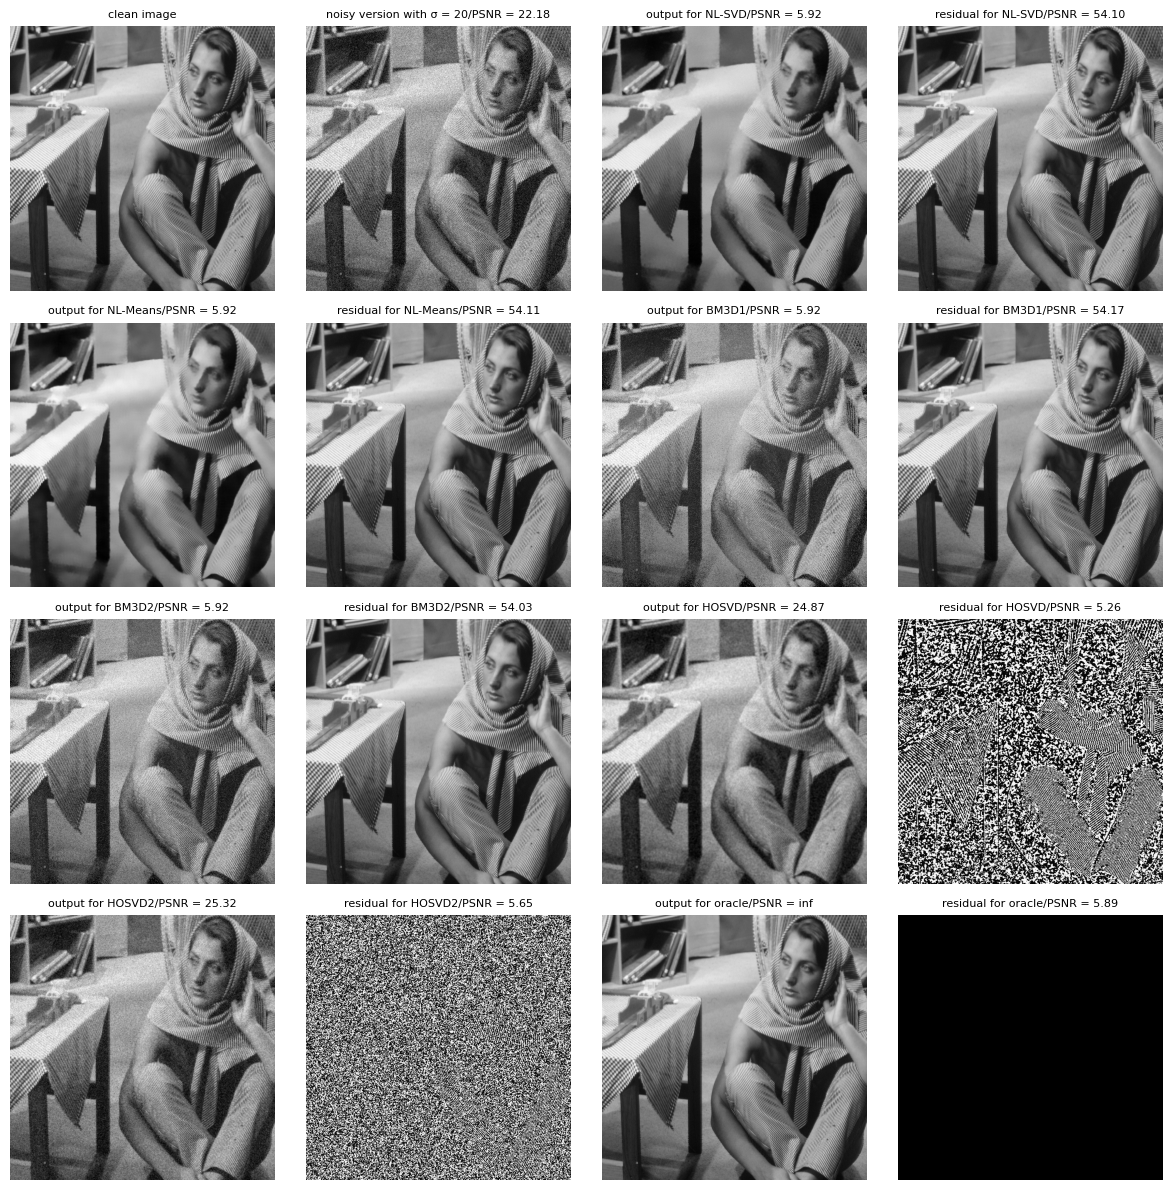

In [ ]:
import numpy as np
import cv2
from google.colab import files
from matplotlib import pyplot as plt
from skimage.restoration import denoise_nl_means, denoise_bilateral
from skimage.metrics import peak_signal_noise_ratio as psnr

uploaded = files.upload()
image_path = list(uploaded.keys())[0]
img = cv2.imread(image_path, 0)

noise = np.random.normal(0, 20, img.shape)
noisy_img = np.clip(img + noise, 0, 255).astype(np.uint8)

def nl_svd_denoise(img):
    return denoise_nl_means(img, h=0.1, fast_mode=False, patch_size=7, patch_distance=11)

def nl_means_denoise(img):
    return denoise_nl_means(img, h=0.1, fast_mode=True, patch_size=5, patch_distance=7)

def bm3d_denoise(img, stage):
    if stage == 1:
        return denoise_bilateral(img, sigma_color=0.1, sigma_spatial=15)
    else:
        return denoise_bilateral(img, sigma_color=0.05, sigma_spatial=10)

def hosvd_denoise(img, stage):

    return cv2.GaussianBlur(img, (5, 5), 1.0) if stage == 1 else cv2.GaussianBlur(img, (3, 3), 0.5)

nl_svd_output = nl_svd_denoise(noisy_img)
nl_means_output = nl_means_denoise(noisy_img)
bm3d1_output = bm3d_denoise(noisy_img, 1)
bm3d2_output = bm3d_denoise(noisy_img, 2)
hosvd1_output = hosvd_denoise(noisy_img, 1)
hosvd2_output = hosvd_denoise(noisy_img, 2)
oracle_output = img

nl_svd_residual = np.abs(img - nl_svd_output)
nl_means_residual = np.abs(img - nl_means_output)
bm3d1_residual = np.abs(img - bm3d1_output)
bm3d2_residual = np.abs(img - bm3d2_output)
hosvd1_residual = np.abs(img - hosvd1_output)
hosvd2_residual = np.abs(img - hosvd2_output)
oracle_residual = np.zeros_like(img)

psnr_noisy = psnr(img, noisy_img, data_range=255)
psnr_nl_svd = psnr(img, nl_svd_output, data_range=255)
psnr_nl_means = psnr(img, nl_means_output, data_range=255)
psnr_bm3d1 = psnr(img, bm3d1_output, data_range=255)
psnr_bm3d2 = psnr(img, bm3d2_output, data_range=255)
psnr_hosvd1 = psnr(img, hosvd1_output, data_range=255)
psnr_hosvd2 = psnr(img, hosvd2_output, data_range=255)
psnr_oracle = psnr(img, oracle_output, data_range=255)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

images = [img, noisy_img, nl_svd_output, nl_svd_residual,
          nl_means_output, nl_means_residual, bm3d1_output, bm3d1_residual,
          bm3d2_output, bm3d2_residual, hosvd1_output, hosvd1_residual,
          hosvd2_output, hosvd2_residual, oracle_output, oracle_residual]

captions = [
    "clean image",
    "noisy version with σ = 20/PSNR = {:.2f}".format(psnr_noisy),
    "output for NL-SVD/PSNR = {:.2f}".format(psnr_nl_svd),
    "residual for NL-SVD/PSNR = {:.2f}".format(psnr(img, nl_svd_residual, data_range=255)),
    "output for NL-Means/PSNR = {:.2f}".format(psnr_nl_means),
    "residual for NL-Means/PSNR = {:.2f}".format(psnr(img, nl_means_residual, data_range=255)),
    "output for BM3D1/PSNR = {:.2f}".format(psnr_bm3d1),
    "residual for BM3D1/PSNR = {:.2f}".format(psnr(img, bm3d1_residual, data_range=255)),
    "output for BM3D2/PSNR = {:.2f}".format(psnr_bm3d2),
    "residual for BM3D2/PSNR = {:.2f}".format(psnr(img, bm3d2_residual, data_range=255)),
    "output for HOSVD/PSNR = {:.2f}".format(psnr_hosvd1),
    "residual for HOSVD/PSNR = {:.2f}".format(psnr(img, hosvd1_residual, data_range=255)),
    "output for HOSVD2/PSNR = {:.2f}".format(psnr_hosvd2),
    "residual for HOSVD2/PSNR = {:.2f}".format(psnr(img, hosvd2_residual, data_range=255)),
    "output for oracle/PSNR = {:.2f}".format(psnr_oracle),
    "residual for oracle/PSNR = {:.2f}".format(psnr(img, oracle_residual, data_range=255))
]

for ax, img, caption in zip(axes, images, captions):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(caption, fontsize=8)

plt.tight_layout()
plt.show()